# Informações

- **Título**: Identificação de Objetos em Imagens e Vídeos
- **Alunos**:
  - Alan Duda dos Santos
  - José Ytalo Ramon de Almeida Gonçalves
- **Disciplina**: Visão Computacional (VC) - 2022.2
- **Professor**: Tácito Trindade de Araújo Tiburtino Neves

- **Repositório**: <https://github.com/jytaloramon/vc-2023-object-detection>

# Imports e montagem (storage)

In [1]:
from google.colab import drive

drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from cv2.dnn import DetectionModel
from matplotlib import ft2font
from google.colab.patches import cv2_imshow

In [3]:
path_dir_work ='/gdrive/My Drive/Classroom/VC - Visão Computacional 2022.2/code'

os.chdir(path_dir_work)

# Classes

## Frame

In [4]:
# Estrutura de dados de definição dos objetos contidos nos frames

class BoxObject:
  def __init__(self, location: tuple[tuple[int, int], tuple[int, int]]) -> None:
    self.__location = location

  def get_location(self) -> tuple[tuple[int, int], tuple[int, int]]:
    return self.__location

  def get_content(self) -> str:
    return 'No Data'


class BoxUniqueObject(BoxObject):

  def __init__(self, label: str,
               confidence: float,
               location: tuple[tuple[int, int], tuple[int, int]]):
    
    super().__init__(location)
    self.__label = label
    self.__confidence = confidence

  def get_label(self) -> str:
    return self.__label

  def get_confidence(self) -> float:
    return self.__confidence

  def get_content(self) -> str:
    return f'{self.__label} {self.__confidence:.2f}'


class BoxMultiObject(BoxObject):

  def __init__(self, labels: set[str],
               confidencies: dict[str, float],
               location: tuple[tuple[int, int], tuple[int, int]]):

    super().__init__(location)
    self.__labels = labels
    self.__confidencies = confidencies

  def get_labels(self) -> set[str]:
    return self.__labels

  def get_confidence(self) -> dict[str, float]:
    return self.__confidencies

  def get_content(self) -> str:
    confidence_label = map(lambda x: f'{x[0]}({x[1]:.2f})',
                           self.__confidencies.items())
    return ','.join(confidence_label)

In [5]:
# Definição dos "frames", dados.

class FrameData:
  def __init__(self, matrix: np.array) -> None:
    self.__matrix = matrix
  
  def get_matrix(self) -> np.array:
    return self.__matrix

  def get_objects_detected(self) -> list[BoxObject]:
    pass


class CommonFrameData(FrameData):

  def __init__(self, matrix: np.array,
               objects_detected: list[BoxUniqueObject]) -> None:
    
    super().__init__(matrix)
    self.__objects_detected = objects_detected

  def get_objects_detected(self) -> list[BoxUniqueObject]:
    return self.__objects_detected


class CleanFrameData(FrameData):

  def __init__(self, matrix: np.array,
               objects_detected: list[BoxMultiObject]) -> None:
    
    super().__init__(matrix)
    self.__objects_detected = objects_detected
  

  def get_objects_detected(self) -> list[BoxMultiObject]:
    return self.__objects_detected

## Construção dos "boxes"

In [6]:
# Classes para construção dos frames com as marcações dos objetos. 

class FrameBuilder:

  def __init__(self,
               colors: list[tuple[int, int, int]],
               font_type: int,
               font_scale: float,
               thickness: int) -> None:
    
    self.__colors = colors
    self.__font_type = font_type
    self.__font_scale = font_scale
    self.__thickness = thickness
    self.__painel_height = 30

  def get_new_matrix(self, frame: FrameData) -> np.array:
    img_cp = frame.get_matrix().copy()

    for i, obj in enumerate(frame.get_objects_detected()):
      start_posi, shape = obj.get_location()
      
      painel_posi = (start_posi[0], start_posi[1] + shape[1] - self.__painel_height)
      painel_shape = (shape[0], self.__painel_height)

      color = self.__colors[i % len(self.__colors)]

      cv2.rectangle(img_cp, painel_posi + painel_shape, color, -1)

      cv2.rectangle(img_cp, start_posi + shape, color, 3)
      
      cv2.putText(img_cp, 
                  obj.get_content(),
                  (painel_posi[0] + self.__painel_height - 5,
                   painel_posi[1] + self.__painel_height - 5),
                  self.__font_type,
                  self.__font_scale,
                  (255, 255, 255),
                  self.__thickness)
      
    return img_cp


class CommonFrameBuilder(FrameBuilder):

  def __init__(self,
               colors: list[tuple[int, int, int]],
               font_type: int,
               font_scale: float,
               thickness: int) -> None:
    
    super().__init__(colors, font_type, font_scale, thickness)


class FusionFrameBuilder(FrameBuilder):

  def __init__(self,
               colors: list[tuple[int, int, int]],
               font_type: int,
               font_scale: float,
               thickness: int) -> None:
    
    super().__init__(colors, font_type, font_scale, thickness)

  def get_new_matrix(self, frame: CommonFrameData) -> np.array:
    img_cp = frame.get_matrix().copy() 

    if len(frame.get_objects_detected()) == 0:
      return img_cp

    first_obj = frame.get_objects_detected()[0]

    new_objects: list[BoxMultiObject] = [
      BoxMultiObject(
        {first_obj.get_label()},
        {first_obj.get_label(): first_obj.get_confidence()},
        first_obj.get_location()
      )
    ]

    for obj in frame.get_objects_detected()[1:]:
      
      actual_labels = { obj.get_label() }
      actual_confidencies = { obj.get_label(): obj.get_confidence() }
      actual_start_p, actual_shape = obj.get_location()

      list_rm: list[BoxMultiObject] = []

      for n_obj in new_objects:
        start_p, shape = n_obj.get_location()
        
        actual_line_x = (actual_start_p[0], actual_start_p[0] + actual_shape[0])
        n_line_x = (start_p[0], start_p[0] + shape[0])

        actual_line_y = (actual_start_p[1], actual_start_p[1] + actual_shape[1])
        n_line_y = (start_p[1], start_p[1] + shape[1])

        if (self.__is_between(actual_line_x, n_line_x) 
            and self.__is_between(actual_line_y, n_line_y)):
          
          actual_labels = actual_labels.union(n_obj.get_labels())
          
          for c in n_obj.get_confidence().items():
             actual_confidencies[c[0]] = min(c[1], 
                                            actual_confidencies[c[0]] 
                                             if actual_confidencies.get(c[0]) is not None 
                                             else 1)

          actual_start_p, actual_shape = self.__get_max_box((actual_start_p, actual_shape),
                                              n_obj.get_location())
          list_rm.append(n_obj)

      for r in list_rm:
        new_objects.remove(r)

      new_objects.append(BoxMultiObject(
          actual_labels,
          actual_confidencies,
          (actual_start_p, actual_shape)))
      
    return super().get_new_matrix(CleanFrameData(frame.get_matrix(), new_objects))

  def __get_max_box(self, obj_1: tuple[tuple[int, int], tuple[int, int]],
                      obj_2: tuple[tuple[int, int], tuple[int, int]]
                     ) -> tuple[tuple[int, int], tuple[int, int]]:

    start_p1, shape1 = obj_1[0], obj_1[1]
    start_p2, shape2 = obj_2[0], obj_2[1]

    end_p1 = (start_p1[0] + shape1[0], start_p1[1] + shape1[1])
    end_p2 = (start_p2[0] + shape2[0], start_p2[1] + shape2[1])

    new_start_p = (min(start_p1[0], start_p2[0]), min(start_p1[1], start_p2[1]))
    new_shape = (max(end_p1[0], end_p2[0]) - new_start_p[0], max(end_p1[1], end_p2[1]) - new_start_p[1])

    return (new_start_p, new_shape)
    
  def __is_between(self, obj_1: tuple[int, int], obj_2: tuple[int, int]) -> bool:
    return (obj_1[0] <= obj_2[0] <= obj_1[1] 
            or obj_1[0] <= obj_2[1] <= obj_1[1]
            or obj_2[0] <= obj_1[0] <= obj_2[1] 
            or obj_2[0] <= obj_1[1] <= obj_2[1])

## Rede

In [68]:
# Classe com atributos relacionados a rede

class DnnTFModel:

  def __init__(self, model: DetectionModel,
               object_class: list[str],
               input_size: tuple[int, int],
               scale: float,
               input_mean: tuple[float, float, float],
               input_swap_rb = True) -> None:
    
    self.__model = model
    self.__model.setInputSize(input_size[0], input_size[1])
    self.__model.setInputScale(scale)
    self.__model.setInputMean(input_mean)
    self.__model.setInputSwapRB(input_swap_rb)
    self.__object_class = object_class

  def detect_objects(self, img: np.array, threshold=0.5) -> CommonFrameData:
    class_index, confidences, boxes = self.__model.detect(img, threshold)
    list_objects: list[BoxUniqueObject] = []

    for dt in zip(class_index, confidences, boxes):
      if dt[0] < 1 or dt[0] > len(self.__object_class):
        continue
        
      label = self.__object_class[dt[0] - 1]
      conf = dt[1]

      start_posi = (dt[2][0], dt[2][1])
      shape = (dt[2][2], dt[2][3])

      list_objects.append(BoxUniqueObject(label, conf, (start_posi, shape)))

    return CommonFrameData(img.copy(), list_objects)

  def __str__(self) -> str:
    class_o = ', '.join(self.__object_class)
    return f'Class Detection: {class_o}'

## Vídeo

In [8]:
# Estrutura de um vídeo. Dados.

class VideoData:

  def __init__(self, frames: list[CommonFrameData],
               builder_common: CommonFrameBuilder,
               builder_fusion: FusionFrameBuilder) -> None:
  
    self.__frames = frames
    self.__builder_common = builder_common
    self.__builder_fusion = builder_fusion

  def save_common(self, name: str):
    list_matrix = []
    for f in self.__frames:
      list_matrix.append(self.__builder_common.get_new_matrix(f))
    
    self.__save_file(list_matrix, name)

  def save_fusion(self, name: str):
    list_matrix = []
    for f in self.__frames:
      list_matrix.append(self.__builder_fusion.get_new_matrix(f))

    self.__save_file(list_matrix, name)

  def __save_file(self, list_matrix, name: str):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    out = cv2.VideoWriter(f'{name}.avi', fourcc, 30.0,
     (len(list_matrix[0][0]), len(list_matrix[0])))

    for m in list_matrix:
      out.write(m)

    out.release()

In [9]:
# Classe de leitura de um vídeo

class ReadVideo:

  def __init__(self, network: DnnTFModel,
               threshold: float,
               builder_common: CommonFrameBuilder,
              builder_fusion: FusionFrameBuilder) -> None:

    self.__network = network
    self.__threshold = threshold
    self.__builder_common = builder_common
    self.__builder_fusion = builder_fusion

  def run(self, path: str) -> VideoData:
    stream_v = cv2.VideoCapture(path)
    frames: CommonFrameData = []

    while stream_v.isOpened():
      read_is_succ, frame = stream_v.read()

      if not read_is_succ:
        break

      new_frame = self.__network.detect_objects(frame, self.__threshold)

      frames.append(new_frame)

    return VideoData(frames, self.__builder_common, self.__builder_fusion)

# Instância: Rede

## Definição das Variaveis 

In [22]:
# Diretórios dos dados

dir_train_name = 'train'

dir_test_name = 'tests'

dir_test_output = 'tests-output'

In [11]:
# Arquivos de treinamento

# Rótulos: classes dos objetos 
filename_yolo_class = 'yolo3.txt'

# Configuração da Rede
filename_coco_network_conf = 'ssd_mobilenet_v3_large_coco.pbtxt' 

# Grafo de inferência
filename_frozen_graph = 'frozen_inference_graph.pb'

In [12]:
# Definições de resoluçao da rede: imagems

input_dimension = 320
size_input = 127.5

## Leitura de Dados e Criação da Rede

In [13]:
# Classes dos objetos 

class_yolo = (open(f'{dir_train_name}/{filename_yolo_class}').read().split('\n'))[:-1]

print(class_yolo)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [69]:
# Intância da rede

tf_network_model = DnnTFModel(
  cv2.dnn_DetectionModel(
    f'{dir_train_name}/{filename_frozen_graph}',
    f'{dir_train_name}/{filename_coco_network_conf}'
  ),
  class_yolo,
  (input_dimension, input_dimension),
  1 / size_input,
  (size_input, size_input, size_input)
)

# Experimentos

In [16]:
# Utils: variáveis

colors = [(0, 204, 0), (0, 0, 255), (0, 51, 204), (156, 0, 255)]
font = cv2.FONT_HERSHEY_DUPLEX
font_scale = 0.75
tickness = 2

threshold = 0.5

In [17]:
# Instâncias dos construtores de frames "marcados".

builder_common = CommonFrameBuilder(colors, font, font_scale, tickness)

builder_fusion = FusionFrameBuilder(colors, font, font_scale, tickness)

## Imagens

### Park

In [18]:
img_park = cv2.imread(f'{dir_test_name}/central-park.jpg')

frame_park = tf_network_model.detect_objects(img_park, threshold)

In [ ]:
cv2_imshow(img_park)

#### Normal

In [30]:
img_park_mod_common = builder_common.get_new_matrix(frame_park)

cv2_imshow(img_park_mod_common)

Output hidden; open in https://colab.research.google.com to view.

#### Com Supressão

In [31]:
img_park_mod_fusion = builder_fusion.get_new_matrix(frame_park)

cv2_imshow(img_park_mod_fusion)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
# Save

cv2.imwrite(f'{dir_test_output}/park-common.png', img_park_mod_common)
cv2.imwrite(f'{dir_test_output}/park-suppression.png', img_park_mod_fusion)

True

### Traffic

In [25]:
img_traffic = cv2.imread(f'{dir_test_name}/traffic.jpeg')

frame_traffic = tf_network_model.detect_objects(img_traffic, threshold)

In [32]:
cv2_imshow(img_traffic)

Output hidden; open in https://colab.research.google.com to view.

#### Normal

In [33]:
img_traffic_mod_common = builder_common.get_new_matrix(frame_traffic)

cv2_imshow(img_traffic_mod_common)

Output hidden; open in https://colab.research.google.com to view.

#### Com Supressão

In [34]:
img_traffic_mod_fusion = builder_fusion.get_new_matrix(frame_traffic)

cv2_imshow(img_traffic_mod_fusion)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
# Save

cv2.imwrite(f'{dir_test_output}/traffic-common.png', img_traffic_mod_common)
cv2.imwrite(f'{dir_test_output}/traffic-suppression.png', img_traffic_mod_fusion)

True

### Car

In [38]:
img_car = cv2.imread(f'{dir_test_name}/car.jpg')

frame_car = tf_network_model.detect_objects(img_car, threshold)

In [39]:
cv2_imshow(img_car)

Output hidden; open in https://colab.research.google.com to view.

In [40]:
img_car_mod_common = builder_common.get_new_matrix(frame_car)

cv2_imshow(img_car_mod_common)

Output hidden; open in https://colab.research.google.com to view.

In [41]:
# Save

cv2.imwrite(f'{dir_test_output}/car-common.png', img_car_mod_common)

True

### Neymar

In [88]:
img_futebol = cv2.imread(f'{dir_test_name}/futebol.jpg')

frame_futebol = tf_network_model.detect_objects(img_futebol, threshold)

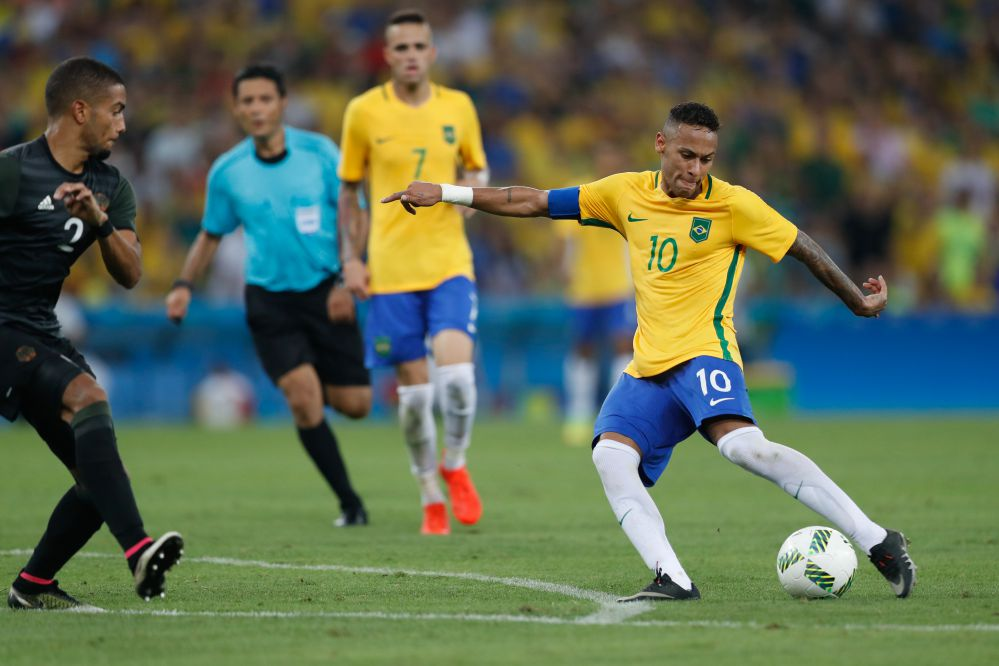

In [89]:
cv2_imshow(img_futebol)

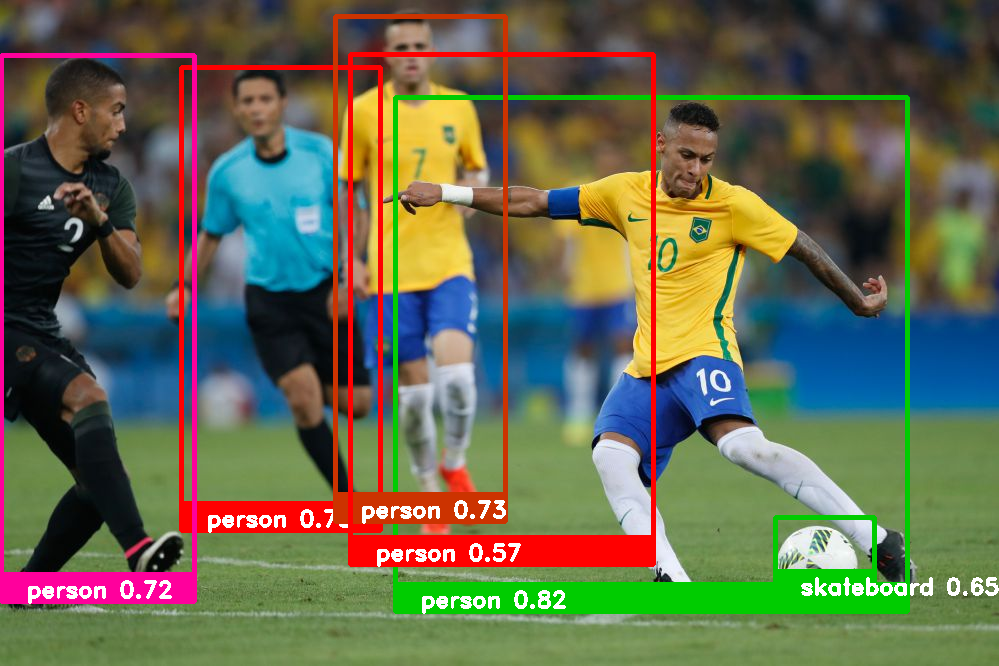

In [90]:
img_futebol_mod_common = builder_common.get_new_matrix(frame_futebol)

cv2_imshow(img_futebol_mod_common)

In [91]:
# Save

cv2.imwrite(f'{dir_test_output}/futebol-common.png', img_futebol_mod_common)

True

### Animais

In [84]:
img_animals = cv2.imread(f'{dir_test_name}/animals.jpg')

frame_animals = tf_network_model.detect_objects(img_animals, threshold)

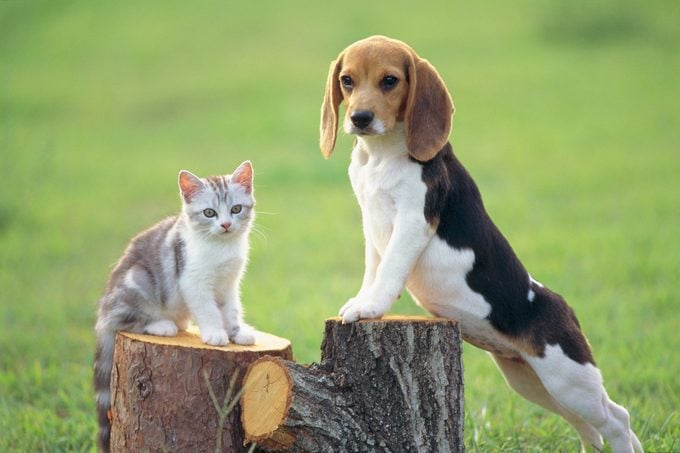

In [85]:
cv2_imshow(img_animals)

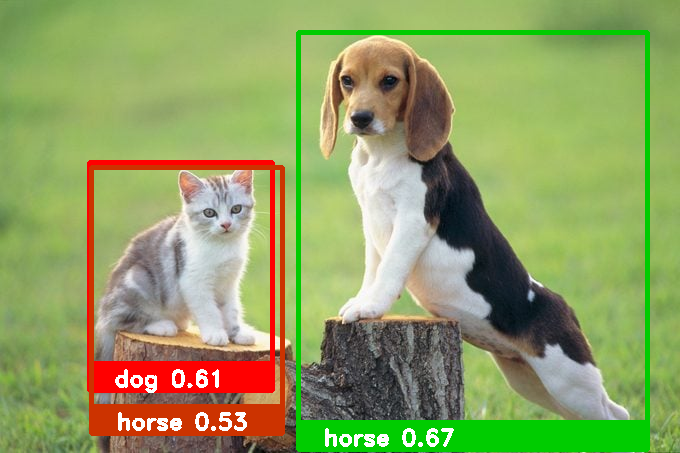

In [87]:
img_animals_mod_common = builder_common.get_new_matrix(frame_animals)

cv2_imshow(img_animals_mod_common)

In [92]:
# Save

cv2.imwrite(f'{dir_test_output}/animals-common.png', img_animals_mod_common)

True

## Vídeos

In [72]:
read_video = ReadVideo(tf_network_model, threshold, builder_common, builder_fusion)

### Moto

In [62]:
video_moto = read_video.run(f'{dir_test_name}/video-moto.mp4')

In [95]:
# Saída: comum
# Assistir em: "tests-output/video-moto-common.avi"

video_moto.save_common(f'{dir_test_output}/video-moto-common')

In [63]:
# Saída: Com Supressão
# Assistir em: "tests-output/video-moto-suppression.avi"

video_moto.save_fusion(f'{dir_test_output}/video-moto-suppression')

### Aero

In [73]:
video_moto = read_video.run(f'{dir_test_name}/video-aero.mp4')

In [74]:
# Saída: comum
# Assistir em: "tests-output/video-aero-common.avi"

video_moto.save_common(f'{dir_test_output}/video-aero-common')